In [1]:
import numpy as np
from autograd import jacobian
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def posi_defnite_check(A):
    """
    check whether the matrix is positive definite
    """
    return np.all(np.linalg.eigvals(A) > 0)

In [3]:
def batch_fun(data, size):
    """
    function for data batch
    """
    n = data.shape[0]
    i = np.arange(n)
    p = data.shape[1]

    ## make sure the rows can be divided by the input size
    if n % size != 0:
        print("The number of observations of data cannot be divided by the input batch size.")
        print('%d data dropped.' % (n % size))

    sample_size = (n // size) * size

    np.random.shuffle(i)

    batch_nums = n // size
    data = data[i][:sample_size].reshape(size, p, batch_nums)
    return (data, batch_nums)

In [4]:
def sghmc(gradU, eps, C, Mmatrix, theta_initial, Cov_hat, epoch_nums, epoch_nums_drop, data, size, seed=663):
    """
    apply the SGHMC function in the paper
    """
    ## gradU: function(theta, X, y), U gradient

    ## eps: learning rate

    ## C: friction matrix P X P

    ## Mmatrix: Mass matrix P X P

    ## theta_initial: initial value of theta

    ## Cov_hat: estimated covariance matrix of stochastic gradient noise

    ## epoch_nums: number of epochs to perform

    ## epoch_nums_drop: number of epochs to drop

    ## size: minbatch size per iteration

    ## seed: seed
    np.random.seed(seed)
    n = data.shape[0]
    p = theta_initial.shape[0]

    theta_samp = np.zeros((p, epoch_nums))
    theta_samp[:, 0] = theta_initial

    B_hat = 0.5 * eps * Cov_hat

    if not posi_defnite_check(2 * (C - B_hat) * eps):
        print("The noise term has to be positive define.")
        return

    noise_sqrt = np.linalg.cholesky(2 * (C - B_hat) * eps)

    r = (np.linalg.cholesky(np.linalg.inv(Mmatrix))) @ np.random.normal(size=p).reshape(p, -1)
    data_batched = batch_fun(data, size)[0]
    batch_nums = batch_fun(data, size)[1]

    for i in range(epoch_nums - 1):
        r = (np.linalg.cholesky(np.linalg.inv(Mmatrix))) @ np.random.normal(size=p).reshape(p, -1)
        theta = theta_samp[:, i]

        for batch in range(batch_nums):
            theta += (eps * Mmatrix @ r).ravel()
            gradU_batch = gradU(theta, data_batched[:, :, batch], n, size).reshape(p, -1)
            r = r - eps * gradU_batch - eps * C @ Mmatrix @ r + noise_sqrt @ np.random.normal(size=p).reshape(p, -1)
        theta_samp[:, i + 1] = theta

    return theta_samp[:, epoch_nums_drop:]

In [5]:
# data and parameters
np.random.seed(663)
n = 100
x = np.zeros((100, 1))
theta_0 = np.array([0.0])
p = theta_0.shape[0]
eps = 0.1
C = np.eye(1)
V = np.eye(1)*4
size = 1
epochs = 4000
burns = 200

In [6]:
def gradU_noise(theta, x, n, size):
    '''noisy gradient from paper fig1'''
    return -4 * theta + 4 * theta**3 + np.random.normal(0, 2)

In [7]:
sim = sghmc(gradU_noise, eps, C, np.eye(p), theta_0, V, epochs, burns, x, size)

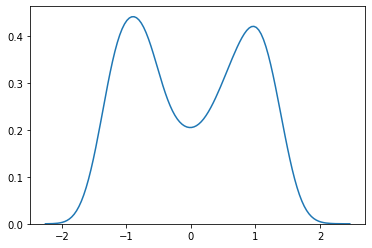

In [9]:
plt = sns.kdeplot(sim[0, :])
fig = plt.get_figure()
fig.show()